#  Product Image Recognition - Deep Learning

In the Consumer Packaged Goods (CPG) industry, product images are becoming popular in web based applications and planogramming tools. Use of  images and alternate views of products enhance user experience and are sometimes more intuitive than textual product descriptions. However it becomes cumbersome and expensive to manage, track and catalog millions of product images manually. The objective of this project is to test and compare various machine learning techniques to classify and label product images into product categories.

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7)
%matplotlib inline

import sys
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from skimage import data, io
from skimage.transform import resize
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


In [ ]:
!curl https://raw.githubusercontent.com/pujari/mlworkshop/master/data/images.zip -o ../images.zip

In [ ]:
!unzip ../images.zip

In [ ]:
!ls images/

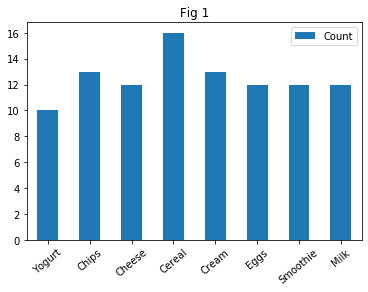

In [3]:
#read ordered labels from CSV file 
labels = pd.read_csv("./images/labels.csv")
y = labels.values.ravel()
num_classes = len(np.unique(y))

df = pd.DataFrame.from_dict(Counter(y), orient='index')
df.columns = ['Count']
df.plot(kind='bar', figsize = (6,4), title = "Fig 1")
locs, labels_text = plt.xticks()
plt.setp(labels_text, rotation=40)
plt.show()

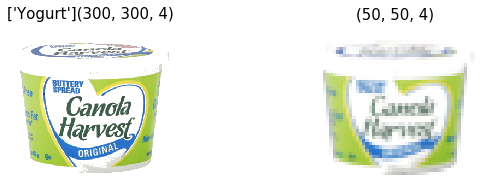

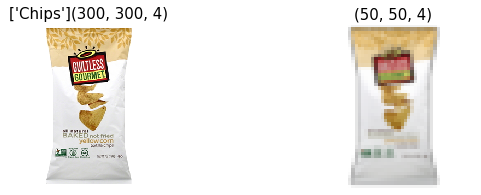

In [4]:
#################################################################
# Read and Process images 
#################################################################
images = []
#global constants
TITLE_SIZE = 15
RANDOM_STATE = 17
IMG_DIM = 50
SAMPLE_SIZE = 100

#read images in order
for i in range(1,SAMPLE_SIZE+1):
    img = io.imread('./images/' + str(i) + '.png')
    img_resized = resize(img, (IMG_DIM, IMG_DIM))
    
    #sample some image feature extraction
    if i <= 2:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
        
        ax1.imshow(img, cmap=plt.cm.jet)
        ax1.axis('off')
        ax1.set_title(str(labels.values[i-1]) + str(img.shape) , fontsize = TITLE_SIZE)

        ax2.imshow(img_resized, cmap=plt.cm.jet)
        ax2.axis('off')
        ax2.set_title(str(img_resized.shape), fontsize = TITLE_SIZE)

    #select the Sobel filter
    images.append(img_resized.ravel())
#end-for

#Convert all images to NP array         
images = np.asarray(images) 

#set X values
X = images

In [5]:
#split train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=RANDOM_STATE)

print ("Total dataset X:", X.shape, "y:", len(y))
print ("Training set:", x_train.shape, "Testing set:" , x_test.shape)
print ("Training Labels:", y_train.shape, "Test Labels:" , y_test.shape)


Total dataset X: (100, 10000) y: 100
Training set: (60, 10000) Testing set: (40, 10000)
Training Labels: (60,) Test Labels: (40,)


## Format data for training

In [6]:
# input image dimensions
img_rows, img_cols = IMG_DIM, IMG_DIM

#split data into train and test 

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 4)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 4)
input_shape = (img_rows, img_cols, 4)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#normalize pixel intensities
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60, 50, 50, 4)
60 train samples
40 test samples


In [7]:
test_labels = y_test

#create binarized labels for training
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

print(y_train.shape, 'train labels')
print(y_test.shape, 'test labels')

y_train[0]

(60, 8) train labels
(40, 8) test labels


array([0, 0, 0, 1, 0, 0, 0, 0])

## Build the CNN

Regularization - BatchNormalization and Dropouts are optional

In [8]:
#Using Keras Sequential API
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## Compile the model
Keras is using TensorFlow as a backend. 

When compiling a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical crossentropy*, and is a loss function well-suited to comparing two probability distributions.

In [9]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

## Visualize the network

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        1184      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)       

## Train Model
Feed the training data loaded in earlier into this model and it will learn to classify digits

In [11]:
batch_size = 10
epochs = 100

In [12]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))

## Evaluate performance

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [0.38416333198547364, 0.925]


## Loss curve

Text(0.5, 1.0, 'Loss Curves')

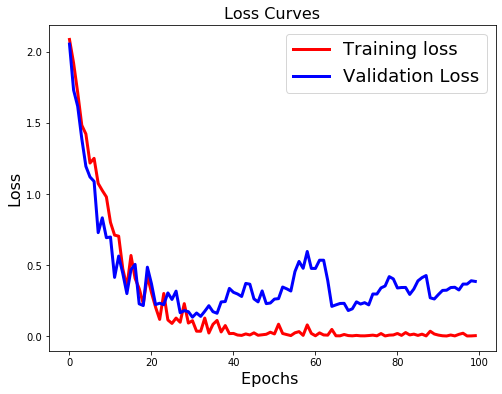

In [14]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

## Inspect the output

Inspect the output and look at some examples it gets right, and some examples it gets wrong. The predict_classes function outputs the highest probability class according to the trained classifier for each input example.

In [15]:
#store the output predictions    
y_pred = model.predict_classes(x_test)
y_pred

array([0, 2, 6, 2, 7, 0, 3, 7, 0, 3, 4, 1, 1, 6, 6, 2, 0, 3, 0, 4, 5, 1,
       7, 1, 0, 3, 5, 4, 5, 6, 1, 5, 2, 1, 4, 2, 1, 2, 1, 6], dtype=int64)

In [16]:
#transform into same form as predictions
y_test = lb.inverse_transform(y_test)

le = LabelEncoder()
y_test = le.fit_transform(y_test)

### Confusion Matrix

In [17]:
pred_labels = le.inverse_transform(y_pred)
pred_labels

array(['Cereal', 'Chips', 'Smoothie', 'Chips', 'Yogurt', 'Cereal',
       'Cream', 'Yogurt', 'Cereal', 'Cream', 'Eggs', 'Cheese', 'Cheese',
       'Smoothie', 'Smoothie', 'Chips', 'Cereal', 'Cream', 'Cereal',
       'Eggs', 'Milk', 'Cheese', 'Yogurt', 'Cheese', 'Cereal', 'Cream',
       'Milk', 'Eggs', 'Milk', 'Smoothie', 'Cheese', 'Milk', 'Chips',
       'Cheese', 'Eggs', 'Chips', 'Cheese', 'Chips', 'Cheese', 'Smoothie'],
      dtype='<U8')

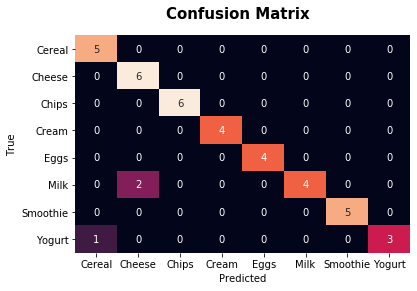

In [18]:
confusion_matrix =  pd.crosstab(index=test_labels, columns=pred_labels.ravel(), rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
# Plot Confusion Matrices
plt.suptitle('Confusion Matrix', fontsize=TITLE_SIZE, fontweight='bold')
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})
plt.subplots_adjust(hspace=.7)  

### Visualize Predictions

In [19]:
#denormalize images
x_test *= 255

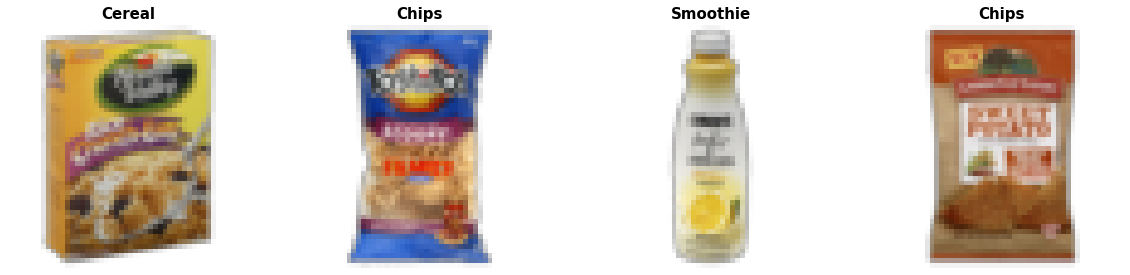

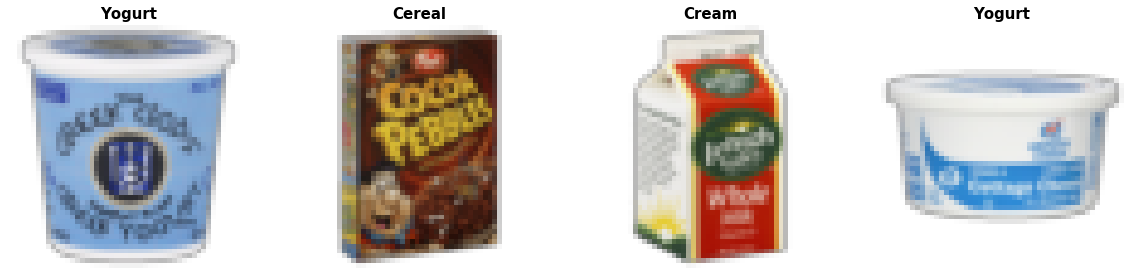

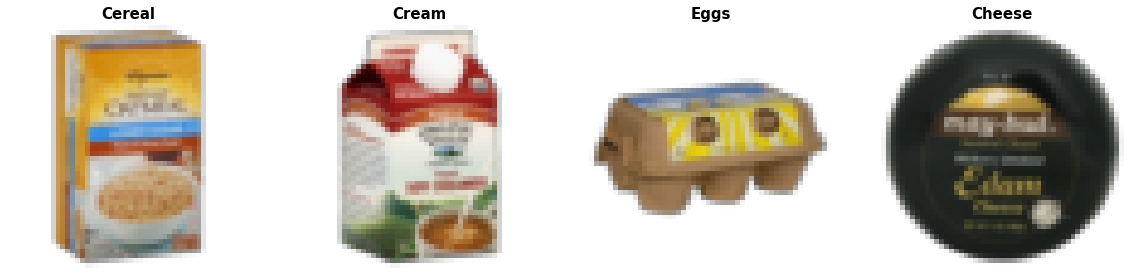

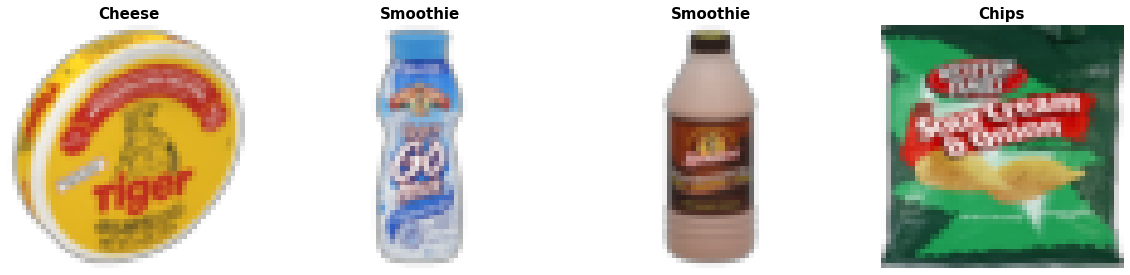

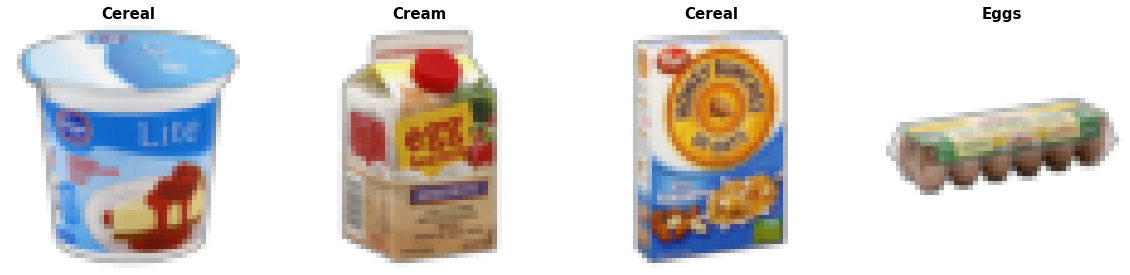

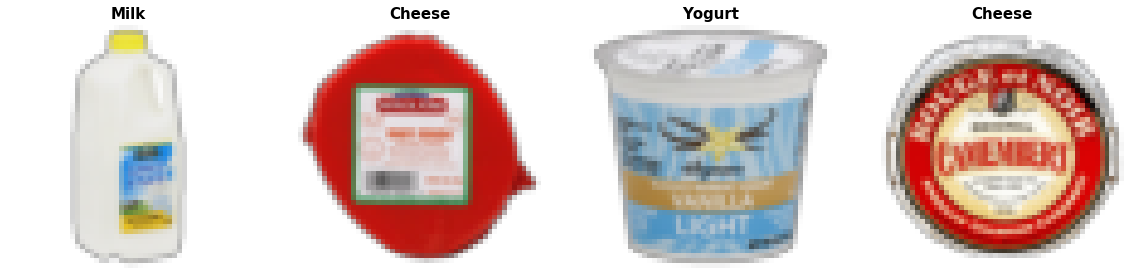

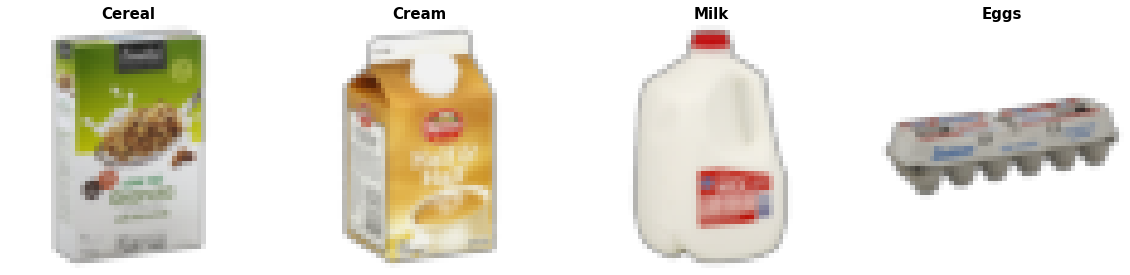

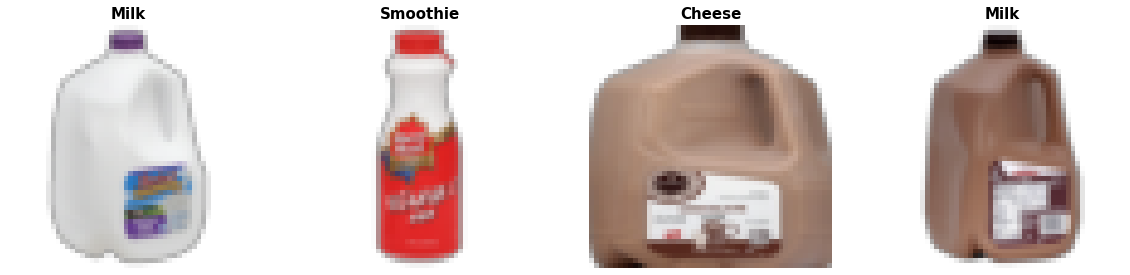

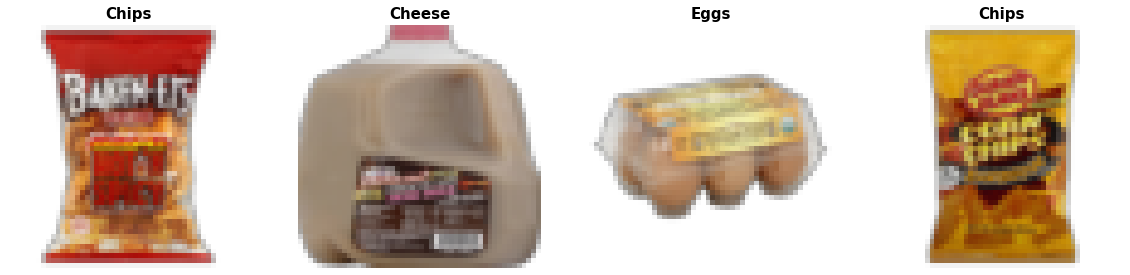

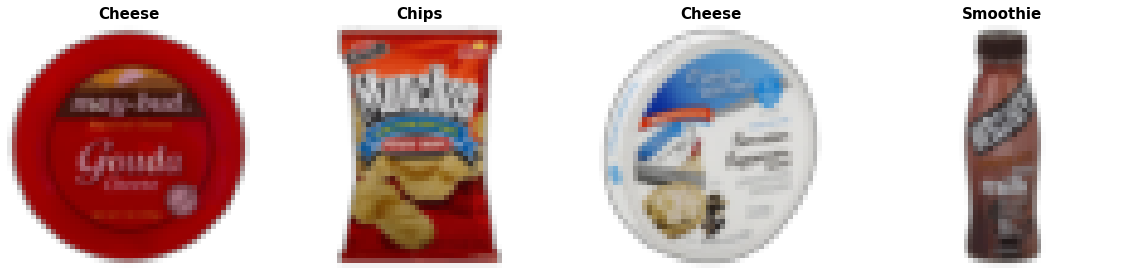

In [20]:
#label images for display
COL_SIZE = 4
for i in range(0,len(x_test),COL_SIZE):
    fig, ax = plt.subplots(nrows=1, ncols=COL_SIZE, figsize=(20, 12))
    for j in range(0,len(ax)):
        if i+j < len(x_test):
            ax[j].imshow(x_test[i+j], cmap=plt.cm.jet)
            ax[j].axis('off')
            ax[j].set_title(pred_labels[i+j], fontsize = TITLE_SIZE, fontweight='bold')